In [28]:
from flakylib import *
import re
import math
import numpy as np
import numba as nb
from numba import prange
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Generation of Synthetic Dataset (Overlapping Blobs on Regular Grid)

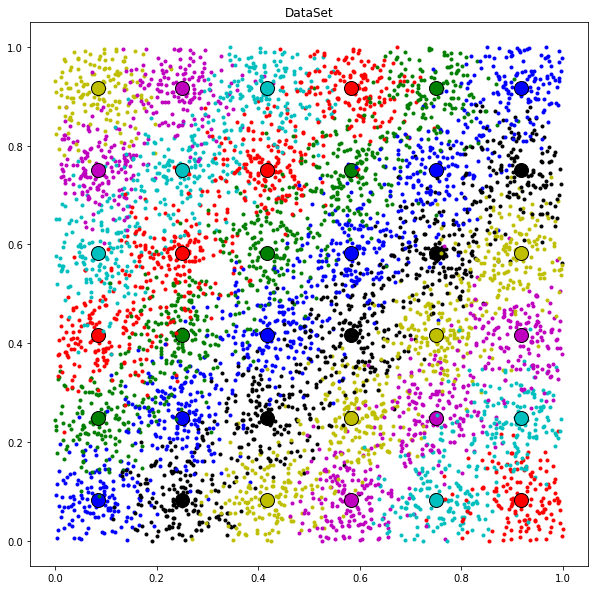

In [29]:
Drawing = True # If n_features > 2 then Drawing = True

grid_size = 6
n_features = 2
n_samples = 6000
standard_deviation = 0.06
n_candidates = 3
nb.config.NUMBA_NUM_THREADS = 8 # The number of CPU cores for the parallel processing


samples, true_sample_membership, true_centroids = generate_blobs_on_grid(n_samples, grid_size, n_features, standard_deviation)

if Drawing:
    draw_dataset(samples, true_centroids, true_sample_membership)
    
n_samples = samples.shape[0]
n_clusters = true_centroids.shape[0]

sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives = empty_state(n_samples, n_features, n_clusters)
   

# Generation of Synthetic Dataset (Random Distributed Blobs)

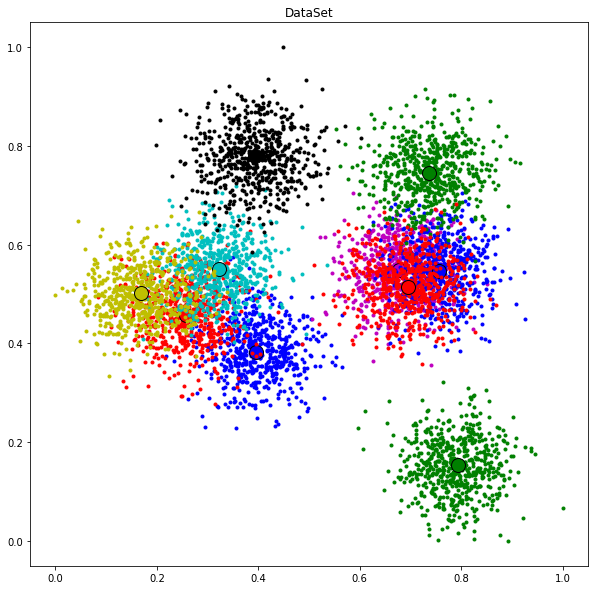

In [3]:
Drawing = True # If n_features > 2 then Drawing = True

grid_size = 6
n_features = 2
n_samples = 6000
standard_deviation = 0.07
n_candidates = 3
nb.config.NUMBA_NUM_THREADS = 8 # The number of CPU cores for the parallel processing
n_cluster = 10

samples, true_centroids, true_sample_membership = generate_dataset1(n_features, n_samples, n_cluster, standard_deviation)


if Drawing:
    draw_dataset(samples, true_centroids, true_sample_membership)
    
n_samples = samples.shape[0]
n_clusters = true_centroids.shape[0]

sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives = empty_state(n_samples, n_features, n_clusters)
   



# Generation of Synthetic Dataset (Random Distributed Samples)

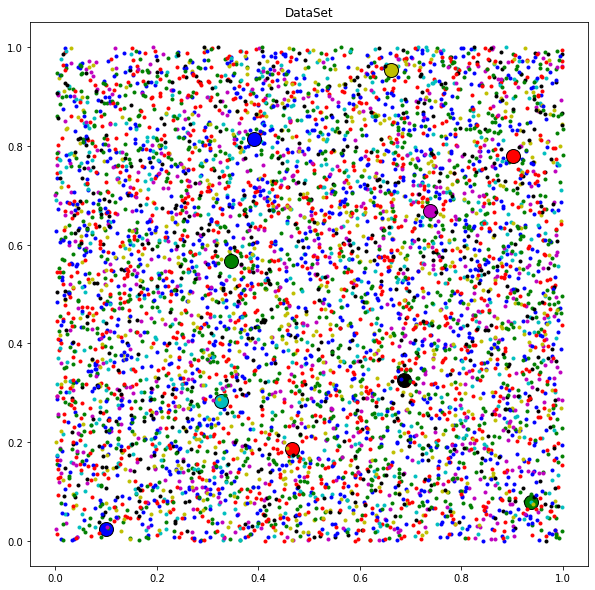

In [4]:
Drawing = True # If n_features > 2 then Drawing = True

n_features = 2
n_samples = 6000
n_clusters = 10
n_candidates = 3
nb.config.NUMBA_NUM_THREADS = 8 # The number of CPU cores for the parallel processing

samples = np.random.sample((n_samples,n_features))

true_sample_membership = np.random.randint(n_clusters, size = n_samples)
true_centroids = np.random.sample((n_clusters,n_features))

if Drawing:
    draw_dataset(samples, true_centroids, true_sample_membership)
    
sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives = empty_state(n_samples, n_features, n_clusters)
 

# Initialization by True Centroids

In [30]:
%%time

centroids = np.copy(true_centroids)

objective, n_changed_membership = assignment(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

print('Objective', objective)
print('')

Objective 23.38180099965823

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.33 ms


# Initialization by Random Centroids

In [31]:
%%time

centroids = np.random.rand(n_clusters, n_features)

objective, n_changed_membership = assignment(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

print('Objective', objective)
print('')


Objective 61.34687460999654

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.14 ms


# Initialization by K-Means++

In [32]:
%%time

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]
centroids_copy = np.copy(centroids)

objective, n_changed_membership = assignment(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

print('Objective', objective)
print('')

Objective 32.872441514169445

CPU times: user 44 ms, sys: 8 ms, total: 52 ms
Wall time: 11.1 ms


# K-Means initialized by True Centroids

In [33]:
%%time

centroids = np.copy(true_centroids)

max_iters = 300
tol=0.000001

objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, max_iters, tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.028401277147758
Iterations: 16
Clusters: 36

CPU times: user 52 ms, sys: 4 ms, total: 56 ms
Wall time: 11.4 ms


# K-Means initialized by K-Means++ with sample_objectives as weights

In [34]:
new_sample_weights = 1-normalization(sample_objectives)
center_inds = k_means_pp(samples, new_sample_weights, n_clusters, n_candidates)
centroids = samples[center_inds]

max_iters = 300
tol=0.000001

objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, max_iters, tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 24.40867902722708
Iterations: 35
Clusters: 36



# K-Means initialized by Random Centroids

In [12]:
%%time

centroids = np.random.rand(n_clusters, n_features)

max_iters = 300
tol=0.000001

objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, max_iters, tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 24.018262371211794
Iterations: 85
Clusters: 35

CPU times: user 260 ms, sys: 0 ns, total: 260 ms
Wall time: 63.7 ms


# K-Means initialized by K-Means++

In [35]:
%%time

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]

max_iters = 300
tol=0.000001

objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, max_iters, tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.52019321164164
Iterations: 59
Clusters: 36

CPU times: user 208 ms, sys: 32 ms, total: 240 ms
Wall time: 40.8 ms


# K-Means initialized by K-Means++ (sklearn)

In [36]:
%%time

# MiniBatchKMeans(KMeans) in SKLEARN ????!!!!

km = KMeans(n_clusters=n_clusters, init = 'k-means++', algorithm = 'full', n_init=1, n_jobs=1)
#km = KMeans(n_clusters=n_clusters, init = 'random', n_init=1, n_jobs=1)
km = km.fit(samples)

print('Objective:', -km.score(samples))
print('Iterations:',km.n_iter_)

Objective: 23.79235250190432
Iterations: 25
CPU times: user 568 ms, sys: 36 ms, total: 604 ms
Wall time: 183 ms


# H-Means (first-improvement strategy) initialized by True Centroids

In [37]:
%%time

centroids = np.copy(true_centroids)

h_max_iters = 30000
h_tol=0.00000001

objective, n_changed_membership = assignment(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

objective = initialize_by_membership(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives)

objective, n_iters = h_means_first(samples, sample_weights, sample_membership, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, h_max_iters, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.028307415500848
Iterations: 8
Clusters: 36

CPU times: user 56 ms, sys: 0 ns, total: 56 ms
Wall time: 51.5 ms


# H-Means (first-improvement strategy) initialized by K-Means++

In [38]:
%%time

centroids = np.copy(centroids_copy)

h_max_iters = 30000
h_tol=0.00000001

objective, n_changed_membership = assignment(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

objective = initialize_by_membership(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives)

objective, n_iters = h_means_first(samples, sample_weights, sample_membership, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, h_max_iters, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.548746667271846
Iterations: 17
Clusters: 36

CPU times: user 132 ms, sys: 0 ns, total: 132 ms
Wall time: 126 ms


# H-Means initialized by Random Membership Distribution

In [39]:
%%time

centroids = np.copy(centroids_copy)

h_max_iters = 30000
h_tol=0.00000001

random_membership(n_samples, n_clusters, sample_membership)

objective = initialize_by_membership(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives)

objective, n_iters = h_means_first(samples, sample_weights, sample_membership, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, h_max_iters, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 24.036687696237372
Iterations: 29
Clusters: 36

CPU times: user 440 ms, sys: 0 ns, total: 440 ms
Wall time: 436 ms


# K-H-Means initialized by True Centroids

In [40]:
%%time

centroids = np.copy(true_centroids)

k_max_iters = 30000
h_max_iters = 30000
k_tol=0.00000001
h_tol=0.00000001

objective, n_iters = k_h_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, k_max_iters, h_max_iters, k_tol, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.02589045664493
Iterations: 20
Clusters: 36

CPU times: user 88 ms, sys: 16 ms, total: 104 ms
Wall time: 45.8 ms


# K-H-Means initialized by K-Means++

In [41]:
%%time

centroids = np.copy(centroids_copy)

k_max_iters = 30000
h_max_iters = 30000
k_tol=0.00000001
h_tol=0.00000001


objective, n_iters = k_h_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, k_max_iters, h_max_iters, k_tol, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.548746667271818
Iterations: 38
Clusters: 36

CPU times: user 148 ms, sys: 32 ms, total: 180 ms
Wall time: 82.4 ms


# Simple Membership Shaking VNS

In [42]:
%%time

max_cpu_time = 10 # seconds
max_iters = 3000 # maximun number of iterations inside VNS

kmax = 3
h_max_iters = 3000
k_max_iters = 3000
h_tol = 0.00000001
k_tol = 0.00000001


#Initialization

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]
objective, n_local_iters = k_h_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, k_max_iters, h_max_iters, k_tol, h_tol)

print('Objective:', objective)
print('Iterations:',n_local_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

#Glogal search

objective, n_iters = Membership_Shaking_VNS(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, k_max_iters, h_max_iters, k_tol, h_tol, kmax, max_cpu_time, max_iters, True)

print('')
print('Final objective:', objective)
print('Total number of iterations:', n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 24.232684684471536
Iterations: 46
Clusters: 36

24.232684684471533 3
24.22525825912094 2
24.223500052316044 2
24.223096165672633 2
24.22245517630179 3
24.22239612198226 2
24.222315700277278 1
24.222315700277274 2
24.22223175881096 1
24.222231758810956 2
24.222050477888352 3
24.218141141861693 3
24.21814114186169 1
24.218141141861683 1
24.21814114186168 3
24.21767727420755 3
24.217677274207542 1
24.21767727420754 1
24.21748852256448 2
24.217488522564476 3
24.217488522564476

Final objective: 24.217488522564476
Total number of iterations: 670
Clusters: 36

CPU times: user 15.4 s, sys: 1.12 s, total: 16.5 s
Wall time: 10.1 s


# Solution Visualization

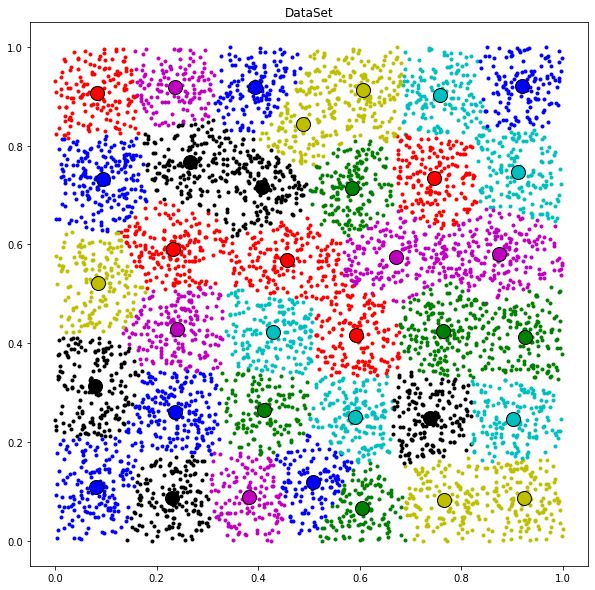

In [43]:
draw_dataset(samples, centroids, sample_membership)

# Local Search by Iteratively New Extra Center Insertion, Searching and Worst Centroid Deletion

In [44]:
%%time

k_max_iters = 600
k_tol=0.000001

max_cpu_time = 10 # seconds
max_iters = 600000
tol=0.000000000000001

#Initialization

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]
objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, k_max_iters, k_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

# Search

objective, n_iters, n_k_iters = iterative_extra_center_insertion_deletion(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, k_max_iters, k_tol, max_iters, tol, max_cpu_time, n_candidates, True)
                                
print('')
print('Objective:', objective)
print('Global Iterations:',n_iters)
print('Local Iterations:',n_k_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.93493698912112
Iterations: 36
Clusters: 36

23.017403568175375
23.01618532616514
22.99769863123794
22.986199085812352
22.985691404594675
22.985691404594675

Objective: 22.985691404594675
Global Iterations: 440
Local Iterations: 28
Clusters: 36

CPU times: user 1min 3s, sys: 5.04 s, total: 1min 8s
Wall time: 10.1 s


# Solution Visualization

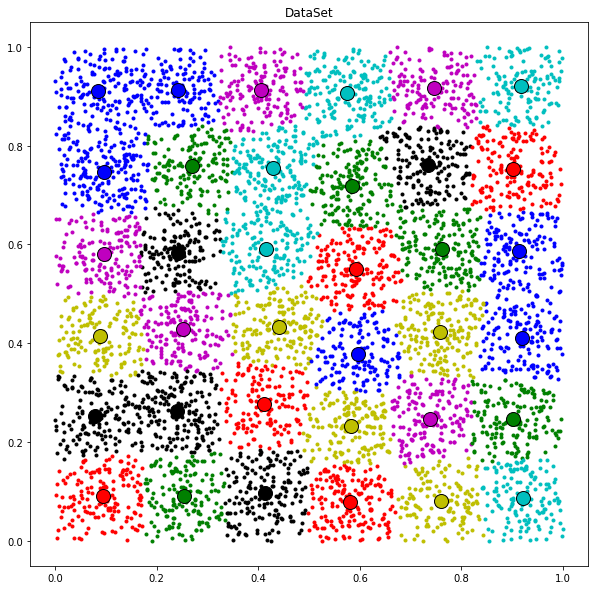

In [45]:
draw_dataset(samples, centroids, sample_membership)

# Simple Center Shaking VNS

In [46]:
%%time

kmax = 5

local_max_iters = 600
local_tol=0.000001

max_cpu_time = 10 # seconds
max_iters = 600000
tol=0.000000000000001

#Initialization

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]
objective, n_local_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, local_max_iters, local_tol)

print('Objective:', objective)
print('Iterations:',n_local_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

# Global Search

objective, n_iters, n_local_iters = Center_Shaking_VNS(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, local_max_iters, local_tol, kmax, max_cpu_time, max_iters, n_candidates, True)

print('')
print('Objective:', objective)
print('Global Iterations:',n_iters)
print('Local Iterations:',n_local_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 24.325888701406363
Iterations: 100
Clusters: 36

24.22609780412222 1
24.22570221235746 1
24.221745605700576 1
24.211816816070336 1
24.211719855706697 1
23.447405331080024 1
23.432670383197 1
23.41869898932286 1
23.418590387886017 1
23.087881887685825 1
23.08709378926086 3
23.016938277436317 4
22.995382293255272 1
22.991324094936445 4
22.9911635610115 1
22.990701028255053 2
22.990681779461056 2
22.990166019729433 1
22.988170884391003 1
22.982830438432494 5
22.982610261156594 1
22.982536331797494 1
22.98247668844654 1
22.982142824501345 3
22.981846054773264 1
22.98176961920491 1
22.981680442582913 1
22.981680442582913

Objective: 22.981680442582913
Global Iterations: 775
Local Iterations: 2
Clusters: 36

CPU times: user 1min, sys: 5.96 s, total: 1min 6s
Wall time: 10.1 s


# Solution Visualization

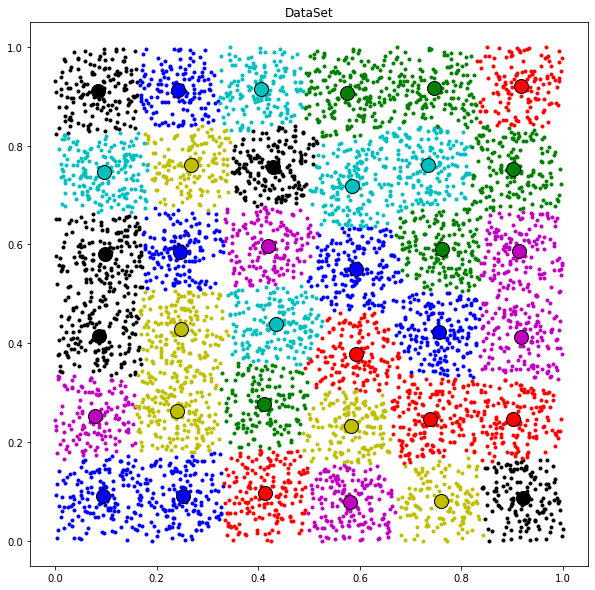

In [47]:
draw_dataset(samples, centroids, sample_membership)

# Sequencing of Different Methods

In [48]:
%%time

printing=True
local_max_iters=300
local_tol=0.00001
n_candidates=3
kmax = 5
max_iters = 3000
max_cpu_time = 3 # seconds


method_sequence = np.array([0, 4, 5, 4, 5, 3])
time_sequence = np.full(method_sequence.shape[0],max_cpu_time)
max_iters_sequence = np.full(method_sequence.shape[0],max_iters)
#kmax_sequence = np.full(method_sequence.shape[0],kmax)
kmax_sequence = np.array([5,5,5,5,15,5])

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]

objective = method_sequencing(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, np.inf, method_sequence, time_sequence, max_iters_sequence, kmax_sequence, local_max_iters, local_tol, n_candidates, printing)

K-means:
23.015319524296004

Center Shaking VNS:
23.013872691959538 3
23.00847362750362 1
22.98612056431143 2
22.984783983110148 3
22.984358943580183 3
22.983294736368006 2
22.983176438961614 1
22.983112137616068 1
22.982589927060015 3
22.982214085514308 1
22.98208981247089 2
22.98208981247089

Membership Shaking VNS:
22.981400086821004 1
22.981400086820997 5
22.98134222845622 1
22.98134222845622

Center Shaking VNS:
22.98134222845622

Membership Shaking VNS:
22.98134222845622

K-H-means:
22.981342228456228

CPU times: user 49.9 s, sys: 4.78 s, total: 54.7 s
Wall time: 12.1 s


# Solution Visualization

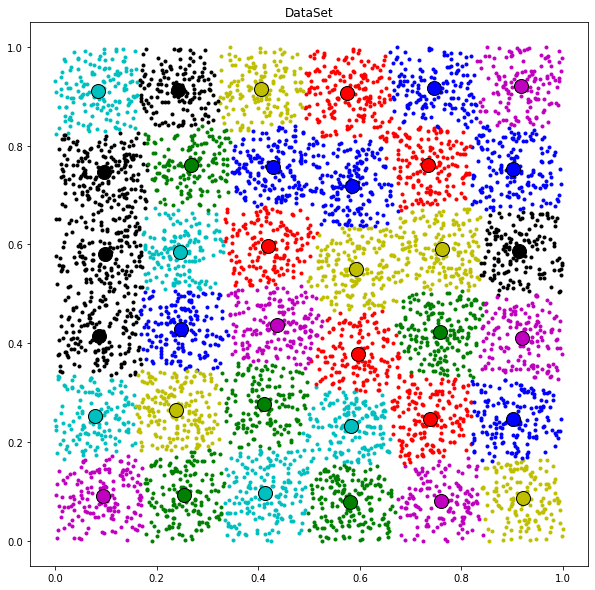

In [49]:
draw_dataset(samples, centroids, sample_membership)

# VNS based Decomposition/Aggregation Minimum Sum-Of-Squares Clustering

In [51]:
%%time

portion_size = 1000
n_portions = 5
init_method = 1
local_max_iters = 3000
local_tol = 0.000000001
max_cpu_time = 3
max_iters = 3000000
n_candidates = 6
aggregation_method = 1
basis_n_init = 3


method_sequence = np.array([0, 4, 5, 4, 5, 3])
kmax_sequence = np.array([0,5,5,5,15,0])
time_sequence = np.full(method_sequence.shape[0],max_cpu_time)
max_iters_sequence = np.full(method_sequence.shape[0],max_iters)


objective, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives = decomposition_aggregation_mssc(samples, sample_weights, method_sequence, time_sequence, max_iters_sequence, kmax_sequence, n_clusters, portion_size, n_portions, init_method, local_max_iters, local_tol, n_candidates, aggregation_method, basis_n_init)



CPU times: user 3min 12s, sys: 17.7 s, total: 3min 30s
Wall time: 1.42 s


In [52]:
objective

22.98131104382047